In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use('default')


## Test the sparsity function

$$\sum_i \log(x_i^2+1)$$

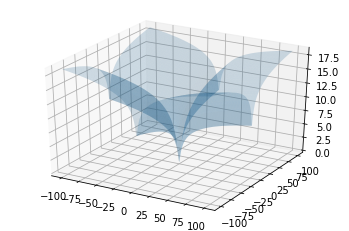

In [ ]:
# Test the sparsity function
x1=np.array([np.arange(-100,100,0.1)]).T
x2=np.array([np.arange(-100,100,0.1)])
y=np.zeros((x1.shape[0], x2.shape[1]))
y=(np.log(1+x1**2)+np.log(1+x2**2))

x1c, x2c=np.meshgrid(x1, x2)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x1c, x2c, y, alpha=.2)
plt.show()

## Faces and magical templates

In [ ]:
r=8
w1=np.zeros((21,21))
x1=np.array([np.arange(21)]).T
x2=np.array([np.arange(21)])
X1, X2=np.meshgrid(x1,x2)
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w1[x1c, x2c]=1
# plt.figure()
# plt.imshow(w1)
# plt.close()
r=6
w2=np.zeros((21,21))
R=(X1-10)**2+(X2-10)**2
x1c, x2c=np.where(np.all([[R<(r+.5)**2],[R>(r-.5)**2]], axis=0).squeeze())
w2[x1c, x2c]=1
# plt.figure()
# plt.imshow(w2)
# plt.close()
r=8
w3=np.zeros((21,21))
w3[2*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[18*np.ones((1,17),dtype=np.int8), 2:19]=1
w3[2:19 ,2*np.ones((1,17),dtype=np.int8)]=1
w3[2:19 ,18*np.ones((1,17),dtype=np.int8)]=1
# plt.imshow(w3)
r=6
w4=np.zeros((21,21))
w4[4*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[16*np.ones((1,13),dtype=np.int8), 4:17]=1
w4[4:17, 4*np.ones((1,13),dtype=np.int8)]=1
w4[4:17, 16*np.ones((1,13),dtype=np.int8)]=1
# plt.imshow(w4)
w5=np.zeros((21,21))
w5[[8,8], [8,12]]=1;
# plt.imshow(w5)
w6=np.zeros((21,21))
w6[9:11, [10,10]]=1;
# plt.imshow(w6)
w7=np.zeros((21,21))
w7[[13,14,14,14,13], [8,9,10,11,12]]=1;
# plt.imshow(w7)
w8=np.zeros((21,21))
w8[[14,13,13,13,14], [8,9,10,11,12]]=1;
# plt.imshow(w7)
# plt.imshow(w1+w5+w6+w8)
# w1, w2, w3, w4
# w5, w6
# w7
# w8
X=np.zeros((8,21*21))
X[0,:]=(w1+w5+w6+w7).reshape((1,21*21))
X[1,:]=(w2+w5+w6+w7).reshape((1,21*21))
X[2,:]=(w3+w5+w6+w7).reshape((1,21*21))
X[3,:]=(w4+w5+w6+w7).reshape((1,21*21))
X[4,:]=(w1+w5+w6+w8).reshape((1,21*21))
X[5,:]=(w2+w5+w6+w8).reshape((1,21*21))
X[6,:]=(w3+w5+w6+w8).reshape((1,21*21))
X[7,:]=(w4+w5+w6+w8).reshape((1,21*21))
X=X.T

W=np.zeros((8,21*21))
W[0,:]=w1.reshape((1,21*21))
W[1,:]=w2.reshape((1,21*21))
W[2,:]=w3.reshape((1,21*21))
W[3,:]=w4.reshape((1,21*21))
W[4,:]=w5.reshape((1,21*21))
W[5,:]=w6.reshape((1,21*21))
W[6,:]=w7.reshape((1,21*21))
W[7,:]=w8.reshape((1,21*21))
W=W.T

## Training naive AE

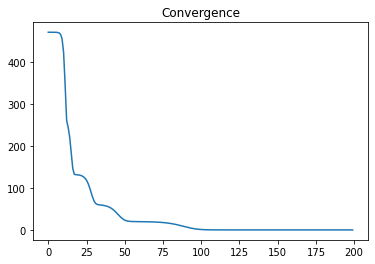

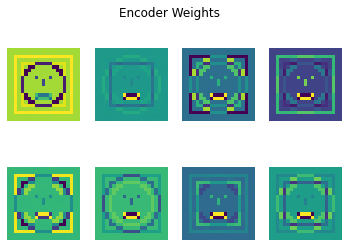

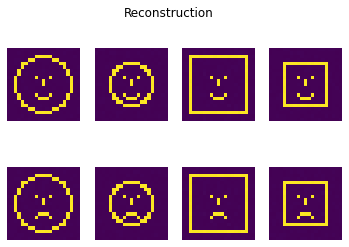

In [ ]:
Xtf=tf.Variable(X, dtype=tf.float32)
lr=tf.constant(.002)
We=tf.Variable((tf.random.uniform((8,21*21))-.5)*.001, dtype=tf.float32)
Wd=tf.transpose(We)

maxIter=200
errt=np.zeros(maxIter)
for i in range(maxIter):
  with tf.GradientTape() as tape:
    Xh=Wd@We@Xtf
    loss=tf.reduce_sum((Xtf-Xh)**2)
  errt[i]=loss.numpy()
  dWe=tape.gradient(loss, We)
  We.assign_sub(lr*dWe)
  Wd=tf.transpose(We)


plt.figure()
plt.plot(errt)
plt.title('Convergence')

plt.figure()
plt.suptitle('Encoder Weights')
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(We.numpy()[i*4+j,:].reshape((21,21)))
    plt.axis('off')


plt.figure()
plt.suptitle('Reconstruction')    
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(Xh.numpy()[:,i*4+j].reshape((21,21)))
    plt.axis('off')

## Training Sparse AE

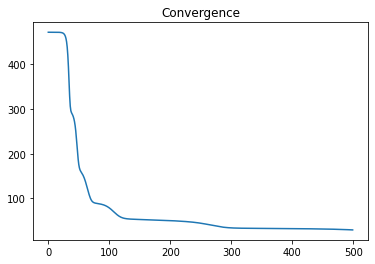

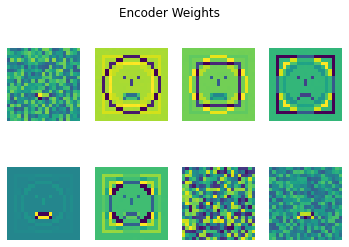

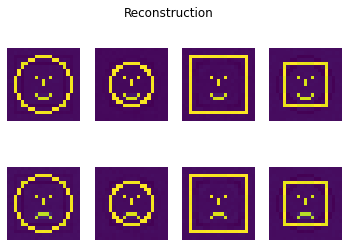

In [ ]:
Xtf=tf.Variable(X, dtype=tf.float32)
lr=tf.constant(.001)
lam=tf.constant(.5)
We=tf.Variable((tf.random.uniform((8,21*21))-.5)*.001, dtype=tf.float32)
Wd=tf.transpose(We)

maxIter=500
errt=np.zeros(maxIter)
for i in range(maxIter):
  with tf.GradientTape() as tape:
    Z=We@Xtf
    Xh=Wd@Z
    loss=tf.reduce_sum((Xtf-Xh)**2)+lam*tf.reduce_sum(tf.math.log(1+Z**2))
  errt[i]=loss.numpy()
  dWe=tape.gradient(loss, We)
  We.assign_sub(lr*dWe)
  Wd=tf.transpose(We)


plt.figure()
plt.plot(errt)
plt.title('Convergence')

plt.figure()
plt.suptitle('Encoder Weights')
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(We.numpy()[i*4+j,:].reshape((21,21)))
    plt.axis('off')


plt.figure()
plt.suptitle('Reconstruction')    
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(Xh.numpy()[:,i*4+j].reshape((21,21)))
    plt.axis('off')



## Nonnegative AE 

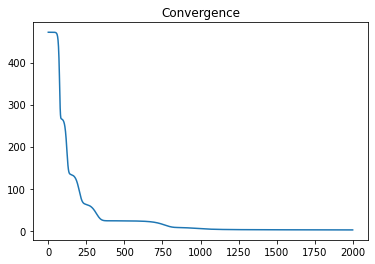

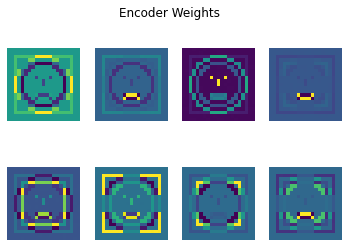

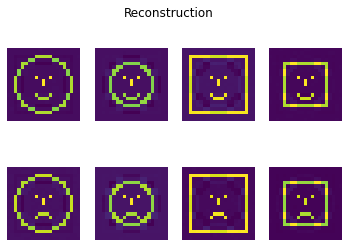

In [ ]:
Xtf=tf.Variable(X, dtype=tf.float32)
lr=tf.constant(.001)
We=tf.Variable((tf.random.uniform((8,21*21))-.5)*.001, dtype=tf.float32)
Wd=tf.transpose(We)

maxIter=2000
errt=np.zeros(maxIter)
for i in range(maxIter):
  with tf.GradientTape() as tape:
    Z=tf.nn.gelu(We)@Xtf
    Xh=tf.nn.gelu(Wd)@Z
    loss=tf.reduce_sum((Xtf-Xh)**2)
  errt[i]=loss.numpy()
  dWe=tape.gradient(loss, We)
  We.assign_sub(lr*dWe)
  Wd=tf.transpose(We)


plt.figure()
plt.plot(errt)
plt.title('Convergence')

plt.figure()
plt.suptitle('Encoder Weights')
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(tf.nn.gelu(We).numpy()[i*4+j,:].reshape((21,21)))
    plt.axis('off')


plt.figure()
plt.suptitle('Reconstruction')    
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(Xh.numpy()[:,i*4+j].reshape((21,21)))
    plt.axis('off')



## Shallow NN for classification, no pretraining, nonlinear hidden units

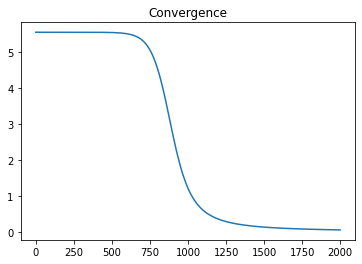

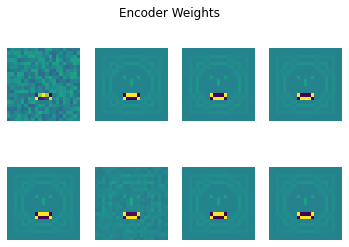

In [ ]:
Xtf=tf.Variable(X, dtype=tf.float32)
lr=tf.constant(.001)
# lam=tf.constant(2.0)

We=tf.Variable((tf.random.uniform((8,21*21))-.5)*.001, dtype=tf.float32)
be=tf.Variable((tf.random.uniform((8,1))-.5)*.001, dtype=tf.float32)
W2=tf.Variable((tf.random.uniform((2,8))-.5)*.001, dtype=tf.float32)
b2=tf.Variable((tf.random.uniform((2,1))-.5)*.001, dtype=tf.float32)

Y=tf.Variable([[1,1,1,1,0,0,0,0], [0,0,0,0,1,1,1,1]], dtype=tf.float32)

maxIter=2000
errt=np.zeros(maxIter)
for i in range(maxIter):
  with tf.GradientTape() as tape:
    Z=tf.nn.relu(We@X+be)
    Yh=W2@Z+b2
    # loss=tf.reduce_sum(-Y*tf.math.log(tf.math.exp(Yh)/tf.reduce_sum(tf.math.exp(Yh), 0, True)))
    loss=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(Y, Yh, axis=0))
  # print(loss)
  errt[i]=loss.numpy()
  delta=tape.gradient(loss, [We, be, W2, b2])
  We.assign_sub(lr*delta[0])
  be.assign_sub(lr*delta[1])
  W2.assign_sub(lr*delta[2])
  b2.assign_sub(lr*delta[3])

plt.figure()
plt.plot(errt)
plt.title('Convergence')

plt.figure()
plt.suptitle('Encoder Weights')
for i in range(2):
  for j in range(4):
    ax=plt.subplot2grid((2, 4), (i, j))
    ax.imshow(We.numpy()[i*4+j,:].reshape((21,21)))
    plt.axis('off')
